<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P1.1_Build_MLP_with_torch.nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Tutorial Overview

 In this tutorial you will learn :
- How to load MNIST dataset by provided torchvision API.
- How to build a simple neural net by basic PyTorch tensor functionality.
- How to refactor the neural net by torch.nn.
- How to extend the neural net to MLP by torch.nn.



Code Adapted from:  What is `torch.nn` *really*?
by Jeremy Howard [fast.ai](https://www.fast.ai). Thanks to Rachel Thomas and Francisco Ingham.



PyTorch provides the elegantly designed modules and classes [torch.nn](https://pytorch.org/docs/stable/nn.html) ,
[torch.optim](https://pytorch.org/docs/stable/optim.html),
[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset),
and [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)
to help you create and train neural networks.
In order to fully utilize their power and customize
them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net
on the MNIST data set without using any features from these models; we will
initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

**This tutorial assumes you are already   familiar
with the basics of tensor operations.** (See the  tutorial P0 for detail).




## 1. MNIST data setup


We will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset,
which consists of black-and-white images of hand-drawn digits (between 0 and 9), and download MNIST dataset using [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)

First, let's import torch, and import MNIST from torchvision.dataset

.


In [1]:
import torch
from torchvision.datasets import MNIST

Then we download MNIST by set `download=True`. We can use `train=True` and `False` to download train and test dataset respectively

In [2]:
mnist_train = MNIST("2AMM10/", train=True, download=True)
mnist_test = MNIST("2AMM10/", train=False, download=True)

0.3%

100.0%


Extracting 2AMM10/MNIST\raw\train-images-idx3-ubyte.gz to 2AMM10/MNIST\raw



100.0%


Extracting 2AMM10/MNIST\raw\train-labels-idx1-ubyte.gz to 2AMM10/MNIST\raw



100.0%


Extracting 2AMM10/MNIST\raw\t10k-images-idx3-ubyte.gz to 2AMM10/MNIST\raw



100.0%

Extracting 2AMM10/MNIST\raw\t10k-labels-idx1-ubyte.gz to 2AMM10/MNIST\raw



Data are flatted by `reshape` and divided by 255 to scale to `[0.0, 1.0]`. 

In [3]:
x_train = mnist_train.data.type(torch.FloatTensor).reshape((-1,784))/255
y_train = mnist_train.targets
x_valid = mnist_test.data.type(torch.FloatTensor).reshape((-1,784))/255
y_valid = mnist_test.targets

print(x_train.type())
print(y_train.type())

torch.FloatTensor
torch.LongTensor


Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



torch.Size([60000, 784])


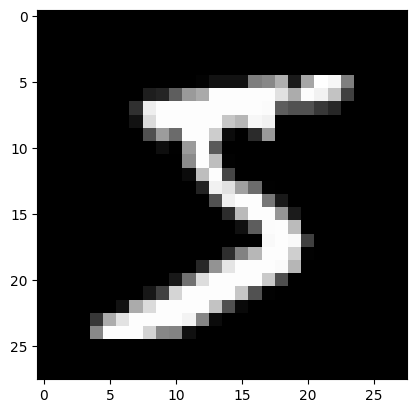

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



# 2. Neural net from scratch (no torch.nn)


Let's first create a model using nothing but PyTorch tensor operations. We're assuming
you're already familiar with the basics of neural networks.

PyTorch provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
gradient. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation *automatically*!

For the weights, we set ``requires_grad`` **after** the initialization, since we
don't want that step included in the gradient. (Note that a trailing ``_`` in
PyTorch signifies that the operation is performed in-place.)


---
**NOTE**

We are initializing the weights here with
   [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
   (by multiplying with 1/sqrt(n))

---

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard function (or callable object) operating on tensors as a model! So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it. Remember: although PyTorch
provides lots of pre-written loss functions, activation functions, and
so forth, you can easily write your own using plain python. PyTorch will
even create fast GPU or vectorized CPU code for your function
automatically.



In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the ``@`` stands for the dot product operation. We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  Note that our predictions won't be any better than
random at this stage, since we start with random weights.



In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
print(f"batch shape: {xb.shape}")
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

batch shape: torch.Size([64, 784])
tensor([-2.2765, -2.3881, -2.2273, -2.6019, -1.9886, -1.7947, -3.1904, -2.2782,
        -2.2620, -2.6203], grad_fn=<SelectBackward0>) torch.Size([64, 10])


As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4476, grad_fn=<NegBackward0>)


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.



In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [12]:
print(accuracy(preds, yb))

tensor(0.0781)


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations in our first tutorial P0.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).


---
**Tip**

You could use [tqdm](https://github.com/tqdm/tqdm) Instantly make your loops show a smart progress

---

In [14]:
from tqdm import tqdm

In [15]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
n = x_train.shape[0]

for epoch in tqdm(range(epochs)):
    for i in range((n - 1) // bs + 1):

        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


That's it: we've created and trained a minimal neural network (in this case without hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0535, grad_fn=<NegBackward0>) tensor(1.)


# 3. Refactor the model by torch.nn

## Using torch.nn.functional


We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating neural
nets, such as pooling functions. (There are also functions for doing convolutions,
linear layers, etc, but as we'll see, these are usually better handled using
other parts of the library.)

If you're using negative log likelihood loss and log softmax activation,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.



In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:



In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0535, grad_fn=<NllLossBackward0>) tensor(1.)


## Refactor using nn.Module

Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.


---
**NOTE**
``nn.Module`` (uppercase M) is a PyTorch specific concept, and is a
   class we'll be using a lot. ``nn.Module`` is not to be confused with the Python
   concept of a (lowercase ``m``) [module](https://docs.python.org/3/tutorial/modules.html),
   which is a file of Python code that can be imported.</p></div>

---

In [19]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [20]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically.



In [21]:
print(loss_func(model(xb), yb))

tensor(2.2463, grad_fn=<NllLossBackward0>)


Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:

```py
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()
```

Now we can take advantage of model.parameters() and model.zero_grad() (which
are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
```py
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

```
We'll wrap our little training loop in a ``fit`` function so we can run it
again later.



In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:



In [23]:
print(loss_func(model(xb), yb))

tensor(0.0546, grad_fn=<NllLossBackward0>)


## Refactor using nn.Linear

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
[nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



In [24]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3465, grad_fn=<NllLossBackward0>)


We are still able to use our same ``fit`` method as before.



In [26]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0543, grad_fn=<NllLossBackward0>)


## Refactor using optim

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
```py
  with torch.no_grad():
      for p in model.parameters(): 
          p -= p.grad * lr
      model.zero_grad()
```
and instead use just:
```py
  opt.step()
  opt.zero_grad()
```
(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)



In [27]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [28]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2855, grad_fn=<NllLossBackward0>)
tensor(0.0533, grad_fn=<NllLossBackward0>)


## Refactor using Dataset


PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.
[This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.



In [29]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [30]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
```py
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Now, we can do these two steps together:
```py
    xb,yb = train_ds[i*bs : i*bs+bs]

```


In [32]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0531, grad_fn=<NllLossBackward0>)


## Refactor using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [33]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
```py
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)
```
Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
```py
      for xb,yb in train_dl:
          pred = model(xb)
```


In [34]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0538, grad_fn=<NllLossBackward0>)


Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effective models in practice.

## Add validation


We were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a [validation set](https://www.fast.ai/2017/11/13/validation-sets/) in order
to identify if you are overfitting.

Shuffling the training data is
[important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.



In [35]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [36]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3104)
1 tensor(0.3102)


## Create fit() and get_data()


We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch and the number of correct predictions.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)
    
    return loss.item(), corrects, len(xb)

``fit`` runs the necessary operations to train our model and compute the training and validation losses, accuracy for each epoch.



In [38]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

   

``get_data`` returns dataloaders for the training and validation sets.



In [39]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [40]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 50%|█████     | 1/2 [00:03<00:03,  3.79s/it]

EPOCH: 1/2 LOSS: 0.3744 ACC: 0.8915  VAL-LOSS: 0.3044 VAL-ACC: 0.9127 


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]

EPOCH: 2/2 LOSS: 0.3043 ACC: 0.9134  VAL-LOSS: 0.3016 VAL-ACC: 0.9161 


# 4. Extend the model to MLP 

The multilayer perceptron model(MLP) is the simplest network. It is an extended version of perceptron with additional hidden nodes between the input and the output layers.  Single-layer perceptron takes data as input and its weights are summed up then an activation function is applied before sent to the output layer. 

![avatar](https://i.stack.imgur.com/VqOpE.jpg)

Unlike the single-layer perceptron, the feedforward models have hidden layers in between the input and the output layers. We are using `ReLU()` as an activation function to introduce non-linearity to the linear output. Given data, Relu sets the threshold for making the decision of whether to pass the information or not. Now let's define a simple MLP with one hidden layer.

In [41]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

We create a little function to create our model and optimizer

In [42]:
def get_mlpmodel():
    model = MLP()
    return model, optim.SGD(model.parameters(), lr=lr)

In [43]:
MLP_model, opt = get_mlpmodel()

Just like what we did before, with 3 lines of code, we run whole process by MLP

In [44]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 50%|█████     | 1/2 [00:03<00:03,  3.26s/it]

EPOCH: 1/2 LOSS: 0.3763 ACC: 0.8917  VAL-LOSS: 0.3014 VAL-ACC: 0.9136 


100%|██████████| 2/2 [00:06<00:00,  3.33s/it]

EPOCH: 2/2 LOSS: 0.3036 ACC: 0.9136  VAL-LOSS: 0.2833 VAL-ACC: 0.9174 


Closing thoughts
-----------------



So let's summarize what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module (usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

